# TAREA #1
Deni Itzae, Abdias, Lizeth
Modelo Lasso para caso Florida RealState

In [66]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from statsmodels.formula.api import ols
from scipy import stats
import plotly.express as px

#
import warnings
warnings.filterwarnings('ignore')

#



## Lectura de Data y su visualización inicial

In [67]:
file_path = 'C:\\Users\\Lizeth Solano Romo\\OneDrive - Universidad Autónoma de Aguascalientes\\2024\\Diplomado UNAM\\Modulo IV\\Tareas\\T1\\FLORIDA2.csv'


#CONVERTIMOS LOS DATOS EN UTF8
try:
    df_florida = pd.read_csv(file_path, encoding='ISO-8859-1')
except UnicodeDecodeError as e:
    print(f"Error al leer el archivo: {e}")
    
                    
df_florida.tail()

,zpid,bedrooms,bathrooms,price,yearBuilt,yearBuilt_cat,zipcode,livingArea,zestimate,zestimateLowPercent,...,priceHistory,TIMEPriceHist,PRICEPriceHist,PRICEsqfPriceHist,PRICEchangeRatePriceHist,EventPriceHist,description,taxAssessedValue_InfoTOD,price_to_rent_ratio_InfoTOD,County
9089,2060674564,NaN,NaN,5000000,1981,8,33325,NaN,NaN,NaN,...,"[{'date': '2022-11-18', 'time': 1668729600000,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Broward
9090,43279128,NaN,NaN,8500000,1981,8,33024,NaN,NaN,NaN,...,"[{'date': '2023-04-28', 'time': 1682640000000,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Broward
9091,2056093684,NaN,NaN,3100000,1981,8,33331,NaN,NaN,NaN,...,"[{'date': '2023-08-08', 'time': 1691452800000,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Broward
9092,43355550,NaN,NaN,3000000,1981,8,33009,NaN,NaN,NaN,...,"[{'date': '2022-02-02', 'time': 1643760000000,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Broward
9093,43355520,NaN,NaN,2890000,1981,8,33009,NaN,NaN,NaN,...,"[{'date': '2023-07-06', 'time': 1688601600000,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Broward


### Limpieza de los datos

In [52]:
def manejar_datos(data):
    # Eliminar columnas con más del 30% de valores nulos
    n_row = data.shape[0]
    nulos = data.isnull().sum()
    columnas_nulos = nulos[nulos > n_row * 0.3].index
    data = data.drop(columns=columnas_nulos)

    # Separar columnas por tipo
    columnas_numericas = data.select_dtypes(include=np.number).columns
    columnas_categoricas = data.select_dtypes(include='object').columns
    columnas_logicas = data.select_dtypes(include='bool').columns

    # Remover outliers en columnas numéricas usando el rango intercuartílico (IQR)
    for col in columnas_numericas:
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        data[col] = np.where((data[col] < lower) | (data[col] > upper), np.nan, data[col])

    # Imputar valores nulos en columnas numéricas con la media
    for col in columnas_numericas:
        data[col] = data[col].fillna(data[col].mean())

    # Imputar valores nulos en columnas categóricas con la moda
    for col in columnas_categoricas:
        moda = data[col].mode().iloc[0]
        data[col] = data[col].fillna(moda)

    # Eliminar columnas categóricas con una sola categoría única
    for col in columnas_categoricas:
        if len(data[col].unique()) == 1:
            data = data.drop(columns=col)

    # Imputar valores nulos en columnas lógicas con la moda
    for col in columnas_logicas:
        moda = data[col].mode().iloc[0]
        data[col] = data[col].fillna(moda)

    # Eliminar columnas lógicas con una sola categoría única
    for col in columnas_logicas:
        if len(data[col].unique()) == 1:
            data = data.drop(columns=col)

    # Eliminar duplicados
    data = data.drop_duplicates()

    return data

# Aplicar la función al DataFrame Base_1
Base_1_limpia = manejar_datos(df_florida)


In [53]:

# Supongamos que df es tu DataFrame en Python

# Convertir yearBuilt a entero redondeando
Base_1_limpia['yearBuilt'] = Base_1_limpia['yearBuilt'].round().astype(int)

# Convertir yearBuilt a cadena de caracteres
Base_1_limpia['yearBuilt'] = Base_1_limpia['yearBuilt'].astype(str)

# Convertir zipcode a entero redondeando
Base_1_limpia['zipcode'] = Base_1_limpia['zipcode'].round().astype(int)

# Convertir bedrooms a entero redondeando
Base_1_limpia['bedrooms'] = Base_1_limpia['bedrooms'].round().astype(int)

# Convertir yearBuilt_cat a cadena de caracteres
Base_1_limpia['yearBuilt_cat'] = Base_1_limpia['yearBuilt_cat'].astype(str)

# Convertir zipcode a cadena de caracteres
Base_1_limpia['zipcode'] = Base_1_limpia['zipcode'].astype(str)


In [54]:
# Seleccionar columnas específicas
Base_elegida = Base_1_limpia[['price', 'bedrooms', 'bathrooms', 'livingArea', 'yearBuilt_cat', 'zipcode', 'city', 'homeType']]

# Obtener resumen estadístico
summary = Base_elegida.describe()

# Imprimir el resumen estadístico
print(summary)


              price     bedrooms    bathrooms   livingArea
count  9.094000e+03  9094.000000  9094.000000  9094.000000
mean   9.109529e+05     3.251704     2.519744  1872.183608
std    5.760598e+05     1.248285     0.761219   820.246065
min    0.000000e+00     0.000000     1.000000     0.000000
25%    5.346000e+05     2.000000     2.000000  1284.250000
50%    7.990000e+05     3.000000     2.519744  1820.000000
75%    1.100000e+06     4.000000     3.000000  2265.750000
max    2.925000e+06     7.000000     4.000000  4477.000000


In [55]:
# Filtrar por rango de precios y área habitable; filtros
Base_elegida = Base_elegida[(Base_elegida['price'] > 100000) & (Base_elegida['price'] < 2000000) & (Base_elegida['livingArea'] > 12) & (Base_elegida['livingArea'] < 5000)]

# Mostrar resumen estadístico
summary = Base_elegida.describe()

# Imprimir el resumen estadístico
print(summary)


              price     bedrooms    bathrooms   livingArea
count  8.386000e+03  8386.000000  8386.000000  8386.000000
mean   8.096358e+05     3.213809     2.483464  1843.440555
std    4.154335e+05     1.240426     0.746660   784.283613
min    1.019000e+05     0.000000     1.000000    13.000000
25%    5.249250e+05     2.000000     2.000000  1270.000000
50%    7.750000e+05     3.000000     2.519744  1770.000000
75%    9.650000e+05     4.000000     3.000000  2204.250000
max    1.999999e+06     7.000000     4.000000  4477.000000


In [56]:

# Conteo de frecuencias para rango de año de construcción
rango_año_construccion = pd.DataFrame(Base_elegida['yearBuilt_cat'].value_counts()).reset_index()
rango_año_construccion.columns = ['yearBuilt_cat', 'Frecuencia']

# Conteo de frecuencias para código postal
codigo_postal = pd.DataFrame(Base_elegida['zipcode'].value_counts()).reset_index()
codigo_postal.columns = ['zipcode', 'Frecuencia']

# Conteo de frecuencias para condado
Condado = pd.DataFrame(Base_elegida['city'].value_counts()).reset_index()
Condado.columns = ['city', 'Frecuencia']

# Conteo de frecuencias para tipo de casa
Tipo_casa = pd.DataFrame(Base_elegida['homeType'].value_counts()).reset_index()
Tipo_casa.columns = ['homeType', 'Frecuencia']


In [57]:

# Agrupar y resumir los datos
data_descriptiva = Base_elegida.groupby(['yearBuilt_cat', 'zipcode', 'city', 'homeType']).agg(
    CONTEO=('price', 'count'),
    Promedio_Precio=('price', 'mean'),
    DS_Precio=('price', 'std'),
    Promedio_hab=('bedrooms', 'mean'),
    SD_hab=('bedrooms', 'std'),
    Promedio_baños=('bathrooms', 'mean'),
    SD_baños=('bathrooms', 'std'),
    Promedio_L_A=('livingArea', 'mean'),
    SD_L_A=('livingArea', 'std')
).reset_index()

# Imprimir el DataFrame resultante
print(data_descriptiva)


     yearBuilt_cat zipcode             city       homeType  CONTEO  \
0              1.0   33127            miami   multi_family       1   
1              1.0   33312  fort_lauderdale  single_family       1   
2             10.0   33004            dania          condo       1   
3             10.0   33004            dania  single_family       1   
4             10.0   33004      dania_beach  single_family       1   
...            ...     ...              ...            ...     ...   
2254           9.0   33334  fort_lauderdale          condo       1   
2255           9.0   33441  deerfield_beach  single_family       2   
2256           9.0   33441  deerfield_beach      townhouse       3   
2257           9.0   33442  deerfield_beach  single_family       4   
2258           9.0   33442  deerfield_beach      townhouse       1   

      Promedio_Precio      DS_Precio  Promedio_hab    SD_hab  Promedio_baños  \
0           1800000.0            NaN      6.000000       NaN        3.000000   

## Estandarización de variables categóricas

In [64]:
df_florida.info()

df_florida.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9094 entries, 0 to 9093
Columns: 160 entries, zpid to County
dtypes: float64(73), int64(5), object(82)
memory usage: 11.1+ MB


Index(['zpid', 'bedrooms', 'bathrooms', 'price', 'yearBuilt', 'yearBuilt_cat',
       'zipcode', 'livingArea', 'zestimate', 'zestimateLowPercent',
       ...
       'priceHistory', 'TIMEPriceHist', 'PRICEPriceHist', 'PRICEsqfPriceHist',
       'PRICEchangeRatePriceHist', 'EventPriceHist', 'description',
       'taxAssessedValue_InfoTOD', 'price_to_rent_ratio_InfoTOD', 'County'],
      dtype='object', length=160)

In [65]:
# Crear una nueva columna con la frecuencia de yearBuilt_cat
yearBuilt_cat_conservar = pd.DataFrame(Base_elegida['yearBuilt_cat'].value_counts()).reset_index()

# Filtrar las categorías que tienen frecuencia mayor o igual a 10
yearBuilt_cat_conservar = yearBuilt_cat_conservar[yearBuilt_cat_conservar['yearBuilt_cat'] >= 10]

# Agregar una nueva columna 'yearBuilt_cat_conservar' con valor 'Si'
yearBuilt_cat_conservar['yearBuilt_cat_conservar'] = 'Si'

# Renombrar las columnas según el código R
yearBuilt_cat_conservar = yearBuilt_cat_conservar.rename(columns={'index': 'yearBuilt_cat'})

# Hacer un left join con el DataFrame original
Base_elegida = pd.merge(Base_elegida, yearBuilt_cat_conservar, on='yearBuilt_cat', how='left')

# Llenar los valores nulos en 'yearBuilt_cat' con 'No se especifica'
Base_elegida['yearBuilt_cat'] = Base_elegida['yearBuilt_cat_conservar'].apply(lambda x: 'No se especifica' if pd.isnull(x) else x)

# Seleccionar las columnas relevantes y eliminar 'yearBuilt_cat_conservar' y 'Freq'
Base_elegida = Base_elegida.drop(['yearBuilt_cat_conservar', 'Freq'], axis=1)


ValueError: The column label 'yearBuilt_cat' is not unique.

## Histogramas de variables de interés

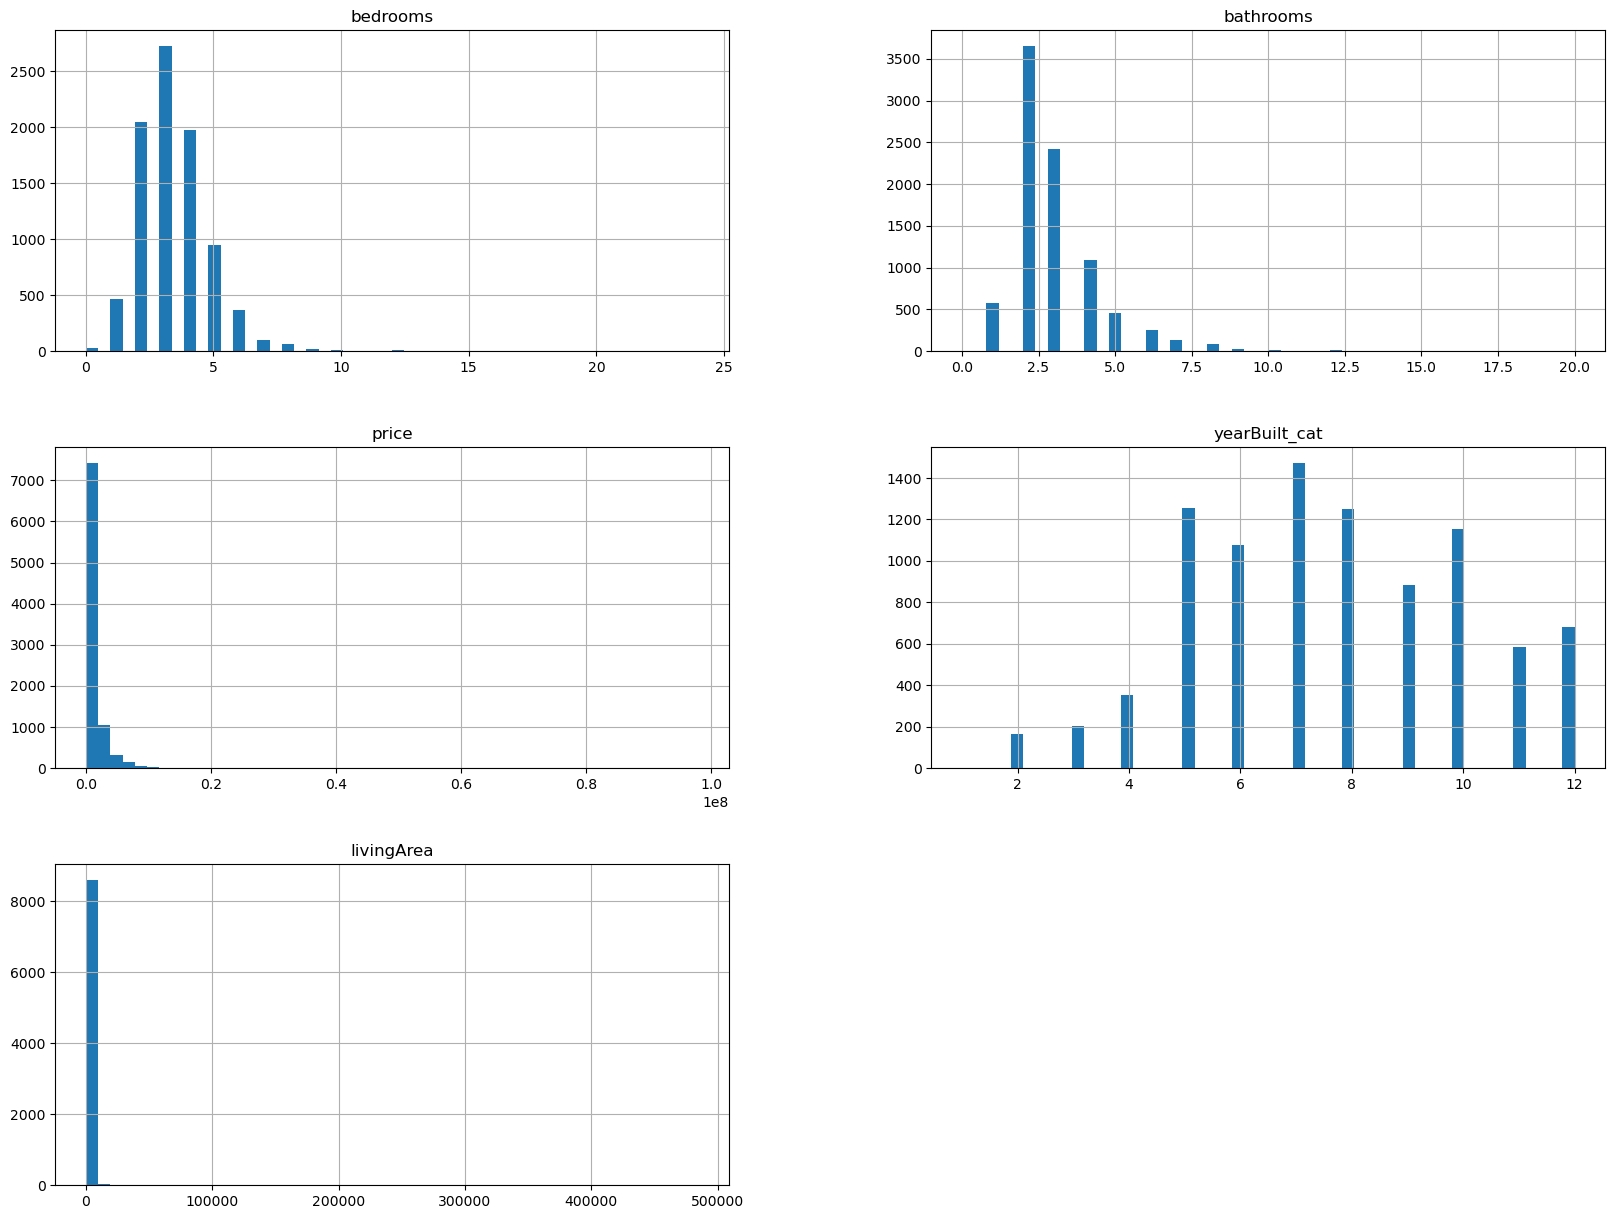

In [68]:
df_florida[['bedrooms', 'bathrooms', 'price', 'yearBuilt_cat', 'livingArea']].hist(bins=50, figsize=(20, 15))
plt.show()

